Andrey_Bondarchuk_stepik_id_346032105

https://colab.research.google.com/drive/1gBoVNDEI3jlRcJcjDVqZaI0_WKe4Oigr?usp=sharing

<img src="https://static.wixstatic.com/media/66c28f_db7a1ba3e35b4b17a6688472c889b7bf~mv2_d_2777_1254_s_2.png/v1/fill/w_710,h_320,al_c,q_85,usm_0.66_1.00_0.01/logo_yellow_white.webp" width=1000, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

# Text Summarization

Всем привет! Сегодня мы познакомимся с задачей суммаризации текста на примере генерации "сжатых" новостей. Рассмотрим некоторые базовые решения и познакомимся с архитектурами нейросетей для решения задачи.
Датасет: gazeta.ru


`Ноутбук создан на основе семинара Гусева Ильи на кафедре компьютерной лингвистики ABBYY МФТИ.`

https://github.com/IlyaGusev/summarus

Загрузим датасет и необходимые библиотеки

In [ ]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [ ]:
!pip -q install razdel networkx pymorphy2 nltk rouge==0.3.1 summa 

     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 8.2 MB 16.7 MB/s 


## Dataset

Посмотрим на то, как устроен датасет

In [ ]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [ ]:
import json
import random

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [ ]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [ ]:
train_records[0]

{'date': '2011-11-30 18:33:39',
 'summary': 'В 2011 году из России уйдет $80 млрд, считают в Минэкономразвития. Менее месяца назад Центробанк давал оценку $70 млрд, повысив первоначальный прогноз вдвое. Отток капитала из страны усиливается из-за кризиса в Европе, а в декабре российским компаниям выплачивать внешние долги. На движение капитала повлияли и выборы: несмотря на их предсказуемость, бизнес хочет ясности с перестановками в правительстве.',
 'text': '«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменени

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])
    
    bleu = 0
    rouge_2f = 0
    
    if metric in ("bleu", "all"):
        bleu = corpus_bleu([[r] for r in references], predictions)
        print("BLEU: ", bleu)
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        rouge_2f = scores['rouge-2']['f']
        print("ROUGE: ", scores)

    return bleu , rouge_2f

## Extractive RNN

### BPE
Для начала сделаем BPE токенизацию

In [ ]:
!pip install youtokentome

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.3 MB/s 


In [ ]:
%%time
import youtokentome as yttm

def train_bpe(records, model_path, model_type="bpe", vocab_size=10000, lower=True):
    temp_file_name = "temp.txt"
    with open(temp_file_name, "w") as temp:
        for record in records:
            text, summary = record['text'], record['summary']
            if lower:
                summary = summary.lower()
                text = text.lower()
            if not text or not summary:
                continue
            temp.write(text + "\n")
            temp.write(summary + "\n")
    yttm.BPE.train(data=temp_file_name, vocab_size=vocab_size, model=model_path)

train_bpe(train_records, "BPE_model.bin")

CPU times: user 27.8 s, sys: 2.29 s, total: 30 s
Wall time: 24.4 s


### Словарь
Составим словарь для индексации токенов

In [ ]:
bpe_processor = yttm.BPE('BPE_model.bin')
vocabulary = bpe_processor.vocab()

### Кэш oracle summary
Закэшируем oracle summary, чтобы не пересчитывать их каждый раз

In [ ]:
%%time

from rouge import Rouge
import razdel
from tqdm.notebook import tqdm

import copy

def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break
        text = record["text"]
        summary = record["summary"]

        summary = summary.lower() if lower else summary
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        record["sentences"] = sentences
        record["oracle_sentences"] = list(sentences_indicies)
        record["oracle_summary"] = oracle_summary

    return records[:nrows]

ext_train_records = add_oracle_summary_to_records(train_records, nrows=2048)
ext_val_records = add_oracle_summary_to_records(val_records, nrows=256)
ext_test_records = add_oracle_summary_to_records(test_records, nrows=256)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

CPU times: user 6min 46s, sys: 1.56 s, total: 6min 48s
Wall time: 6min 49s


Сериализуем объекты, чтобы при перезапуске ноутбука не терять время на построение oracle summary

In [ ]:
import pickle

In [ ]:
with open('ext_train_records.pickle', 'wb') as f:
    pickle.dump(ext_train_records, f)
with open('ext_val_records.pickle', 'wb') as f:
    pickle.dump(ext_val_records, f)
with open('ext_test_records.pickle', 'wb') as f:
    pickle.dump(ext_test_records, f)

In [ ]:
with open('ext_train_records.pickle', 'rb') as f:
    ext_train_records = pickle.load(f)
with open('ext_val_records.pickle', 'rb') as f:
    ext_val_records = pickle.load(f)
with open('ext_test_records.pickle', 'rb') as f:
    ext_test_records = pickle.load(f)

Посмотрим на балансировку классов, рассчитиаем веса классов на train для Кросс-Энтропии. Расчет весов классов будем проводить по формуле

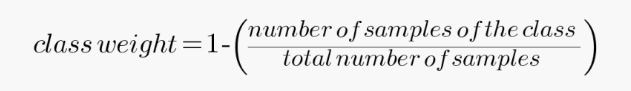

In [ ]:
count_positive_class = 0
count_all_class = 0
for record in ext_train_records:
    count_positive_class += len(record['oracle_sentences'])
    count_all_class += len(record['sentences']) 
# нулевой класс, первый класс (0, 1) 
weights= [count_positive_class/count_all_class,  1 - count_positive_class/count_all_class]
weights

[0.07688880511335401, 0.923111194886646]

In [ ]:
assert sum(weights) == 1

**Вывод: Классы несбалансированы. Поэтому для целевого класса необходимо увеличить вес.**

### Составление батчей

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import random
import math
import razdel
import torch
import numpy as np
from rouge import Rouge


class BatchIterator():
    def __init__(self, records, vocabulary, batch_size, bpe_processor, shuffle=True, lower=True, max_sentences=30, max_sentence_length=50, device=torch.device('cpu')):
        self.records = records
        self.num_samples = len(records)
        self.batch_size = batch_size
        self.bpe_processor = bpe_processor
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device
        
    def __len__(self):
        return self.batches_count
    
    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]

            batch_inputs = []
            batch_outputs = []
            max_sentence_length = 0
            max_sentences = 0
            batch_records = []

            for data_ind in batch_indices:
                
                record = self.records[data_ind]
                batch_records.append(record)
                text = record["text"]
                summary = record["summary"]
                summary = summary.lower() if self.lower else summary

                if "sentences" not in record:
                    sentences = [sentence.text.lower() if self.lower else sentence.text for sentence in razdel.sentenize(text)][:self.max_sentences]
                else:
                    sentences = record["sentences"]
                max_sentences = max(len(sentences), max_sentences)
                
                # номера предложений, которые в нашем саммари
                if "oracle_sentences" not in record:
                    calc_score = lambda x, y: calc_single_score(x, y, self.rouge)
                    sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=calc_score, lower=self.lower, max_sentences=self.max_sentences)[1]
                else:   
                    sentences_indicies = record["oracle_sentences"]
                
                # inputs - индексы слов в предложении
                inputs = [bpe_processor.encode(sentence)[:self.max_sentence_length] for sentence in sentences]
                max_sentence_length = max(max_sentence_length, max([len(tokens) for tokens in inputs]))
                
                # получение метки класса предложения
                outputs = [int(i in sentences_indicies) for i in range(len(sentences))]
                batch_inputs.append(inputs)
                batch_outputs.append(outputs)

            tensor_inputs = torch.zeros((self.batch_size, max_sentences, max_sentence_length), dtype=torch.long, device=self.device)
            # we add index 2 for padding
            # YOUR CODE ------------------------------------------------------------------------------------------------
            tensor_outputs = 2 * torch.ones((self.batch_size, max_sentences), dtype=torch.float32, device=self.device)
            # ----------------------------------------------------------------------------------------------------------
  
            for i, inputs in enumerate(batch_inputs):
                for j, sentence_tokens in enumerate(inputs):
                    tensor_inputs[i][j][:len(sentence_tokens)] = torch.tensor(sentence_tokens, dtype=torch.int64)

            for i, outputs in enumerate(batch_outputs):
                tensor_outputs[i][:len(outputs)] = torch.LongTensor(outputs)

            tensor_outputs = tensor_outputs.long()
            yield {
                'inputs': tensor_inputs,
                'outputs': tensor_outputs,
                'records': batch_records
            }

In [ ]:
train_iterator = BatchIterator(ext_train_records, vocabulary, 32, bpe_processor, device=device)
val_iterator = BatchIterator(ext_val_records, vocabulary, 32, bpe_processor, device=device)
test_iterator = BatchIterator(ext_test_records, vocabulary, 32, bpe_processor, device=device)

## Extractor -  SummaRuNNer
 https://arxiv.org/pdf/1611.04230.pdf


### Homework

* В данной реализации в `outputs` в качестве padding используется индекс 0. Измените в функции \_\_iter__ индекс padding, чтобы он не совпадал с классом 0 или 1, например, 2.
* В качестве criterion используйте `CrossEntropyLoss`вместо `BCEWithLogitsLoss`
* Из-за смены criterion, вы уже должны подавать на вход criterion ни одно число, а logits для каждого класса. Перед подачей logits вы можете отфильтровать предсказания для класса padding. В этом пункте вам придется изменять файл `train_model.py`, а именно функциии `train` и `evaluate`.
* Используйте два варианта обучения: c весами в `CrossEntropyLoss` и без
* Также сравните `inference`, когда вы ранжируете logits, и когды вы выбирате предложения, у котрых logits > 0, в двух вариантах обучения. 
* Реализуйте дополнительно характеристику предложения `novelty`. Как влияет добавление `novelty` на качество summary?
* Постарайтесь улучшить качество модели, полученной на семинаре: $BLEU \approx 0.45$

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, n_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        embedded = self.dropout_layer(self.embedding_layer(inputs))
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)
        # [batch_size, hidden_size]
        return sentences_embeddings

class SentenceTaggerRNN(nn.Module):
    def __init__(self,
                 vocabulary_size,
                 use_content=True,
                 use_salience=True,
                 use_novelty=True,
                 token_embedding_dim=128,
                 sentence_encoder_hidden_size=256,
                 hidden_size=256,
                 bidirectional=True,
                 sentence_encoder_n_layers=2,
                 sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True,
                 n_layers=2,
                 dropout=0.3):
        
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.sentence_encoder = SentenceEncoderRNN(vocabulary_size, token_embedding_dim,
                                                   sentence_encoder_hidden_size, sentence_encoder_n_layers, 
                                                   sentence_encoder_dropout, sentence_encoder_bidirectional)
        
        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)
        
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1)
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
       
        # YOUR CODE ------------------------------------------------------------------------------------------
        self.novelty_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2, bias=False)
        # ----------------------------------------------------------------------------------------------------

        self.tanh_layer = nn.Tanh()

        self.use_content = use_content
        self.use_salience = use_salience
        self.use_novelty = use_novelty

    def forward(self, inputs, hidden=None):
        # parameters of the probability
        content = 0
        salience = 0
        novelty = 0

        # [batch_size, seq num, seq_len]
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)
        inputs = inputs.reshape(-1, tokens_count)
        # [batch_size * seq num, seq_len]

        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = self.dropout_layer(embedded_sentences.reshape(batch_size, sentences_count, -1))
        # [batch_size *  seq num, seq_len, hidden_size] -> [batch_size, seq num, hidden_size]

        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        # [batch_size, seq num, hidden_size]

        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        # [batch_size, hidden_size]

        # W * h^T
        if self.use_content:
            content = self.content_linear_layer(outputs).squeeze(2) # 1-representation
        # [batch_size, seq num]

        # h^T * W * d
        if self.use_salience:
            salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2) # 2-representation
        # [batch_size, seq num, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, seq num, ]

        if self.use_novelty:
            # at every step add novelty to prediction of the sentence
            predictions = content + salience
            
            # 0) initialize summary_representation and novelty by zeros
            # YOUR CODE --------------------------------------------------------------
            summary_representation = embedded_sentences.new_zeros((batch_size, self.hidden_size * 2))
            novelty = content.new_zeros((batch_size, sentences_count))
            # ------------------------------------------------------------------------

            for sentence_num in range(sentences_count):
                pass
                # 1) take sentence_num_state from outputs(representation of the sentence with number sentence_num)
                # 2) calculate novelty for current sentence
                # 3) add novelty to predictions
                # 4) calculcate probability for current sentence
                # 5) add sentence_num_state with the weight which is equal to probability to summary_representation 

                # YOUR CODE ---------------------------------------------------------------------------------------
                novelty_intermediate = self.novelty_linear_layer(torch.tanh(summary_representation)).unsqueeze(2)
                sentence_num_state = outputs[:, sentence_num, :]
                novelty[:, sentence_num] = -torch.bmm(sentence_num_state.unsqueeze(1), novelty_intermediate).squeeze(2).squeeze(1)
                predictions[:, sentence_num] += novelty[:, sentence_num]
                probabilities = torch.sigmoid(predictions[:, sentence_num])
                summary_representation += torch.mv(sentence_num_state.transpose(0, 1), probabilities)
                # -------------------------------------------------------------------------------------------------

        return content + salience + novelty

## Model
$P\left(y_{j} = 1 \mid \mathbf{h}_{j}, \mathbf{s}_{j}, \mathbf{d}\right)=\sigma\left(W_{c} \mathbf{h}_{j} + \mathbf{h}_{j}^{T} W_{s} \mathbf{d}\right)$
--------------------

https://arxiv.org/pdf/1611.04230.pdf

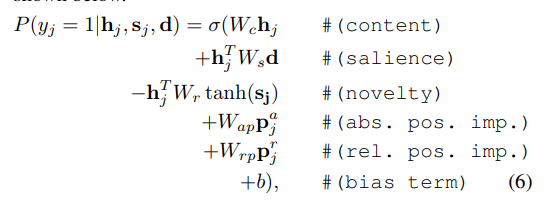

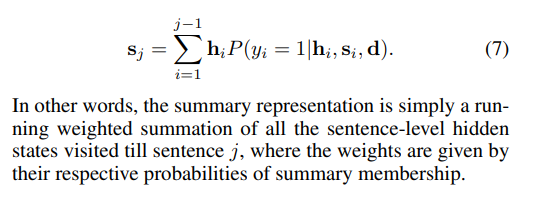

In [ ]:
vocab_size = len(vocabulary)

model = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)

params_count = np.sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Trainable params: {}".format(params_count))

Trainable params: 2927361


In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")

sentence_encoder.embedding_layer.weight: 1280000
sentence_encoder.rnn_layer.weight_ih_l0: 65536
sentence_encoder.rnn_layer.weight_hh_l0: 65536
sentence_encoder.rnn_layer.bias_ih_l0: 512
sentence_encoder.rnn_layer.bias_hh_l0: 512
sentence_encoder.rnn_layer.weight_ih_l0_reverse: 65536
sentence_encoder.rnn_layer.weight_hh_l0_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l0_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l0_reverse: 512
sentence_encoder.rnn_layer.weight_ih_l1: 131072
sentence_encoder.rnn_layer.weight_hh_l1: 65536
sentence_encoder.rnn_layer.bias_ih_l1: 512
sentence_encoder.rnn_layer.bias_hh_l1: 512
sentence_encoder.rnn_layer.weight_ih_l1_reverse: 131072
sentence_encoder.rnn_layer.weight_hh_l1_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l1_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l1_reverse: 512
rnn_layer.weight_ih_l0: 131072
rnn_layer.weight_hh_l0: 65536
rnn_layer.bias_ih_l0: 512
rnn_layer.bias_hh_l0: 512
rnn_layer.weight_ih_l0_reverse: 131072
rnn_layer.wei

### Файл train_model.py

In [ ]:
#!gdown https://drive.google.com/uc?id=1MiS_iczALcyF7zGDPY6niyeD82P0_PBH -O train_model.py
# import train_model
# import imp 
# imp.reload(train_model)
# from train_model import train_with_logs

Downloading...
From: https://drive.google.com/uc?id=1MiS_iczALcyF7zGDPY6niyeD82P0_PBH
To: /content/drive/MyDrive/train_model.py
100% 4.31k/4.31k [00:00<00:00, 5.90MB/s]


In [ ]:
import matplotlib
import time
import math
import torch
import re
import razdel
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
from IPython.display import clear_output

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        # YOUR CODE ------------------------------------------------------------
        labels = batch['outputs'].view(-1) 
        class_1 = model(batch['inputs']).view(-1)
        class_1 = torch.sigmoid(class_1)
        class_0 = torch.ones(class_1.shape[0]).to(device) - class_1
        logits = torch.cat([class_0.unsqueeze(1),class_1.unsqueeze(1)], - 1)
        
        loss = criterion(logits, labels)
        # ----------------------------------------------------------------------
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        history.append(loss.item())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            # YOUR CODE --------------------------------------------------------
            labels = batch['outputs'].view(-1)       
            class_1 = model(batch['inputs']).view(-1)
            class_1 = torch.sigmoid(class_1)
            class_0 = torch.ones(class_1.shape[0]).to(device) - class_1
            logits = torch.cat([class_0.unsqueeze(1),class_1.unsqueeze(1)], - 1)
            
            loss = criterion(logits, labels)
            # ------------------------------------------------------------------
            
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def train_with_logs(model, train_iterator, valid_iterator, optimizer, criterion, N_EPOCHS, CLIP):
    
    train_history = []
    valid_history = []    
    
    best_valid_loss = float('inf')
    best_epoch = 0
    for epoch in range(N_EPOCHS):
        
        start_time = time.time()
        
        train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
        valid_loss = evaluate(model, valid_iterator, criterion)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best-val-model.pt')
            best_epoch = epoch 
        
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print(f'BEST Epoch: {best_epoch+1:02}' )
        
def punct_detokenize(text):
    text = text.strip()
    punctuation = ",.!?:;%"
    closing_punctuation = ")]}"
    opening_punctuation = "([}"
    for ch in punctuation + closing_punctuation:
        text = text.replace(" " + ch, ch)
    for ch in opening_punctuation:
        text = text.replace(ch + " ", ch)
    res = [r'"\s[^"]+\s"', r"'\s[^']+\s'"]
    for r in res:
        for f in re.findall(r, text, re.U):
            text = text.replace(f, f[0] + f[2:-2] + f[-1])
    text = text.replace("' s", "'s").replace(" 's", "'s")
    text = text.strip()
    return text


def postprocess(ref, hyp, is_multiple_ref=False, detokenize_after=False, tokenize_after=True):
    if is_multiple_ref:
        reference_sents = ref.split(" s_s ")
        decoded_sents = hyp.split("s_s")
        hyp = [w.replace("<", "&lt;").replace(">", "&gt;").strip() for w in decoded_sents]
        ref = [w.replace("<", "&lt;").replace(">", "&gt;").strip() for w in reference_sents]
        hyp = " ".join(hyp)
        ref = " ".join(ref)
    ref = ref.strip()
    hyp = hyp.strip()
    if detokenize_after:
        hyp = punct_detokenize(hyp)
        ref = punct_detokenize(ref)
    if tokenize_after:
        hyp = hyp.replace("@@UNKNOWN@@", "<unk>")
        hyp = " ".join([token.text for token in razdel.tokenize(hyp)])
        ref = " ".join([token.text for token in razdel.tokenize(ref)])
    return ref, hyp

## Тренеруем модели и сохраняем веса 

In [ ]:
N_EPOCHS = 20
CLIP = 1
LR = 5e-6

In [ ]:
def _train(model, use_class_weights, N_EPOCHS, CLIP, lr=LR):
    optimizer = optim.Adam(model.parameters(), lr)
    if use_class_weights:
        # weights depend on the number of objects of class 0 and 1
        # YOUR CODE ------------------------------------------------------------
        count_positive_class = 0
        count_all_class = 0
        for record in ext_train_records:
            count_positive_class += len(record['oracle_sentences'])
            count_all_class += len(record['sentences'])

        weights= [count_positive_class/count_all_class,  1 - count_positive_class/count_all_class]
        weights = torch.tensor(weights)
        # ----------------------------------------------------------------------
        criterion = nn.CrossEntropyLoss(weight=weights, ignore_index = 2)
    else:
        criterion = nn.CrossEntropyLoss(ignore_index = 2)

    loss_function = criterion.to(device)
    
    train_with_logs(model, train_iterator, val_iterator, optimizer, loss_function, N_EPOCHS, CLIP)

### Модель NoNoveltyNoWeights (без novelty и без балансировки весов )

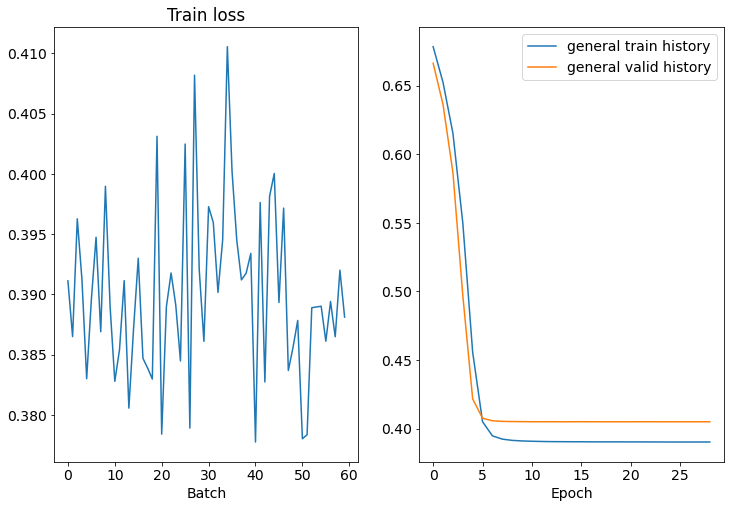

Epoch: 30 | Time: 0m 9s
	Train Loss: 0.390 | Train PPL:   1.477
	 Val. Loss: 0.405 |  Val. PPL:   1.499
BEST Epoch: 29


In [ ]:
model = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)
_train(model, False, 30, CLIP)

**Вывод:** Модель начиная с 5 эпохи практически перестает обучаться.

Сохраним веса модели в отдельном файле

In [ ]:
!cp best-val-model.pt NoNoveltyNoWeights.pt

### Модель WithNoveltyNoWeights (c novelty и без балансировки весов)

In [ ]:
model = SentenceTaggerRNN(vocab_size, use_novelty=True).to(device)

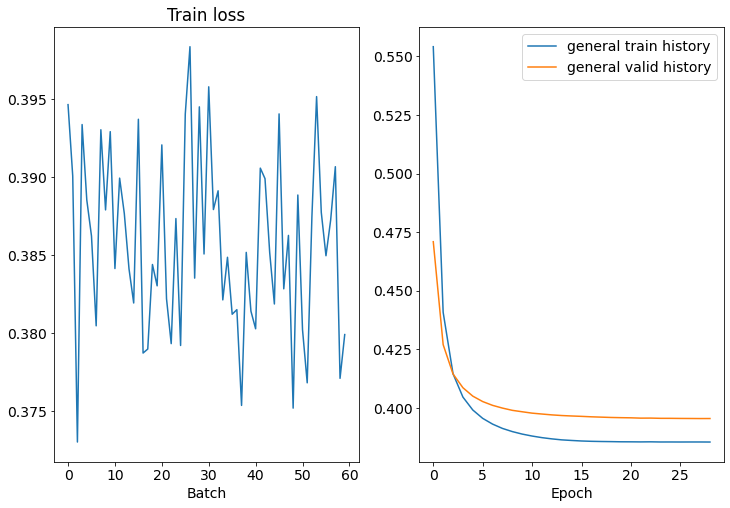

Epoch: 30 | Time: 0m 10s
	Train Loss: 0.385 | Train PPL:   1.470
	 Val. Loss: 0.395 |  Val. PPL:   1.485
BEST Epoch: 28


In [ ]:
_train(model, False, 30, CLIP)

У данной модели наименьший лосс за 30 эпох.

In [ ]:
!cp best-val-model.pt WithNoveltyNoWeights.pt

### Модель NoNoveltyWithWeights (без novelty с балансировкой весов)

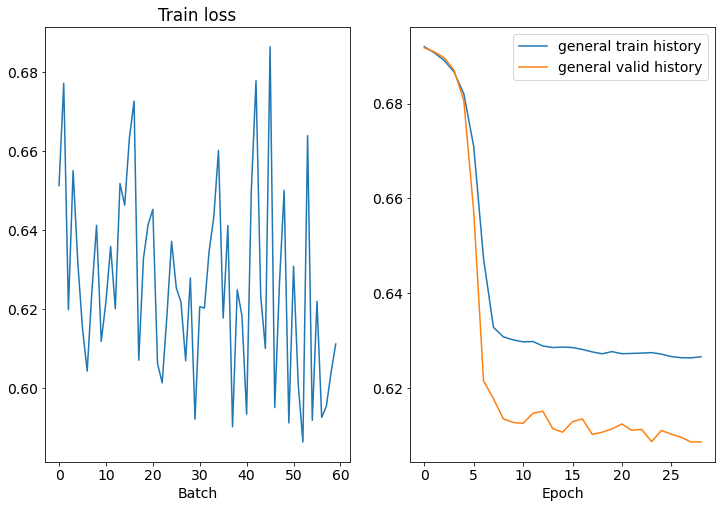

Epoch: 30 | Time: 0m 9s
	Train Loss: 0.627 | Train PPL:   1.871
	 Val. Loss: 0.610 |  Val. PPL:   1.841
BEST Epoch: 28


In [ ]:
model = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)
_train(model, True, 30, CLIP, lr = LR)

In [ ]:
!cp best-val-model.pt NoNoveltyWithWeights.pt

### Модель WithNoveltyWithWeights (c novelty с балансировкой весов)

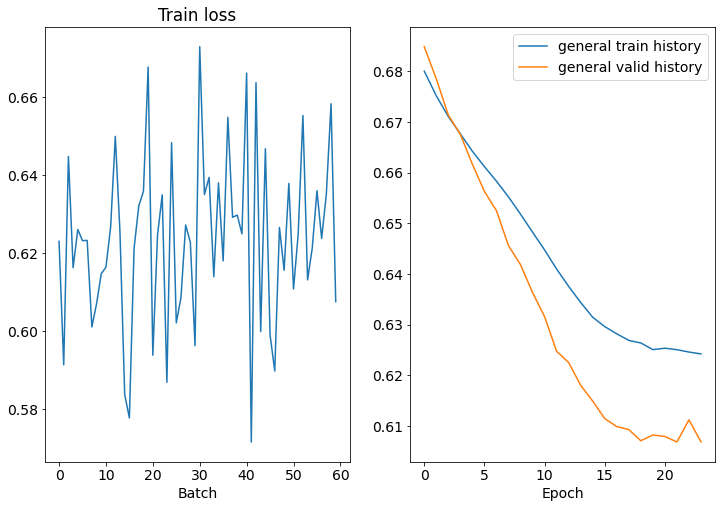

Epoch: 25 | Time: 0m 10s
	Train Loss: 0.624 | Train PPL:   1.867
	 Val. Loss: 0.607 |  Val. PPL:   1.835
BEST Epoch: 22


In [ ]:
model = SentenceTaggerRNN(vocab_size, use_novelty=True).to(device)
_train(model, True, 25, CLIP, lr = LR)

In [ ]:
!cp best-val-model.pt WithNoveltyWithWeights.pt

## Inference

Функция расчета метрик с ранжированием

In [ ]:
#from train_model import punct_detokenize, postprocess

def inference_summarunner_argsort(model, iterator, top_k=3):

    references = []
    predictions = []

    model.eval()
    for batch in test_iterator:

        labels = batch['outputs']
        logits = model(batch['inputs'])
        logits = torch.where( (labels!=2), logits, (torch.ones(labels.shape)* (- 1000.)).to(device)) #без паддинга  
        sum_in = torch.argsort(logits, dim=1)[:, -top_k:]
        
        for i in range(len(batch['outputs'])):

            summary = batch['records'][i]['summary'].lower()
            pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in.sort(dim=1)[0][i]])
            summary, pred_summary = postprocess(summary, pred_summary)

            references.append(summary)
            predictions.append(pred_summary)

    bleu, rouge_2f = calc_scores(references, predictions)
    return bleu, rouge_2f

Функция расчета метрик с отсечкой логитов по порогу

In [ ]:
def inference_summarunner_treshhold(model, iterator, treshhold = 1.7):

    references = []
    predictions = []

    model.eval()
    for batch in iterator:

        labels = batch['outputs']
        logits = model(batch['inputs'])
        logits = torch.where( (logits >= treshhold), logits, (torch.ones(labels.shape)* (- 1.)).to(device)) 
 
        for i in range(labels.shape[0]):
            sum_in = [ind for ind in range(labels.shape[1]) if (logits[i][ind] > 0)] 
            if len(sum_in) == 0:
                continue     
            
            summary = batch['records'][i]['summary'].lower()  

            pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in])
            summary, pred_summary = postprocess(summary, pred_summary)
    
            references.append(summary)
            predictions.append(pred_summary)

    if len(predictions) == 0:
        bleu, rouge_2f = (0. , 0.)
    else:    
        bleu, rouge_2f = calc_scores(references, predictions)
    
    return bleu, rouge_2f

Веса обученных моделей загружаем с google диска.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd ./drive/MyDrive
# %ls

/content/drive/MyDrive


Собирать результаты будем для итоговой таблицы в pandas dataframe

In [ ]:
import pandas as pd

In [ ]:
pd_list = []

### Модель NoNoveltyNoWeights (без novelty и без балансировки весов )

In [ ]:
model = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)
model.load_state_dict(torch.load('NoNoveltyNoWeights.pt', map_location=torch.device(device)))

<All keys matched successfully>

#### Ранжирование

In [ ]:
bleu, rouge_2f = inference_summarunner_argsort(model, test_iterator, 3)

Count: 256
Ref: опасные трещины найдены уже в десятках самолетов boeing 737 ng . американскому производителю , чьи новейшие лайнеры и так прикованы к земле из-за двух авиакатастроф , теперь грозят новые убытки .
Hyp: подозрения , павшие почти две недели назад на один из самых массовых самолетов в мире boeing 737 ng , подтвердились и теперь могут привести к отзыву треснувших самолетов , а для boeing — обернуться новыми репутационными и финансовыми потерями . как сообщают американские сми , число дефектных самолетов уже измеряется десятками . о новой проблеме с популярными лайнерами семейства boeing 737 стало известно в конце сентября , когда инженеры компании случайно обнаружили трещины в их конструкции .
BLEU:  0.4215674985857657
ROUGE:  {'rouge-1': {'f': 0.29638653870477505, 'p': 0.2743133305107193, 'r': 0.34076586516959567}, 'rouge-2': {'f': 0.1277542601866094, 'p': 0.11594179678790467, 'r': 0.15211318224762435}, 'rouge-l': {'f': 0.25148457570056376, 'p': 0.24628925786354472, 'r': 0.

In [ ]:
pd_list.append({'novelty':'Нет','weigts':'Нет', 'inference':'argsort','BLEU':round(bleu,7),'rouge_2f':round(rouge_2f,7)})

#### Отсечка логитов 

In [ ]:
bleu, rouge_2f = inference_summarunner_treshhold(model, test_iterator, 0)

In [ ]:
pd_list.append({'novelty':'Нет','weigts':'Нет', 'inference':'treshhold - 0.0','BLEU':round(bleu,7),'rouge_2f':round(rouge_2f,7)})

In [ ]:
pd.DataFrame(pd_list)

,novelty,weigts,inference,BLEU,rouge_2f
0,Нет,Нет,argsort,0.421567,0.127754
1,Нет,Нет,treshhold - 0.0,0.000000,0.000000


### Модель WithNoveltyNoWeights (c novelty и без балансировки весов)

In [ ]:
model = SentenceTaggerRNN(vocab_size, use_novelty=True).to(device)
model.load_state_dict(torch.load('WithNoveltyNoWeights.pt', map_location=torch.device(device)))

<All keys matched successfully>

#### Ранжирование

In [ ]:
bleu, rouge_2f = inference_summarunner_argsort(model, test_iterator, 3)

Count: 256
Ref: в российском совете по правам человека — серьезные кадровые перестановки . указом президента назначен новый председатель совета — это журналист и экс-секретарь общественной палаты валерий фадеев . предыдущий глава спч михаил федотов покинул свой пост , согласно официальной версии , из-за достижения предельного возраста пребывания на госслужбе . при этом сми со ссылкой на источники сообщают , что есть и другие причины кадровых изменений в спч .
Hyp: новым председателем совета при президенте россии по развитию гражданского общества и правам человека ( спч ) назначен журналист и общественный деятель валерий фадеев . соответствующий указ уже подписан президентом рф . сми со ссылкой на источники , знакомые с ситуацией , сообщают , что отставка федотова связана не только с возрастом , но и с его деятельностью .
BLEU:  0.41253144093742955
ROUGE:  {'rouge-1': {'f': 0.2892309994568357, 'p': 0.264988854783944, 'r': 0.33547180794457643}, 'rouge-2': {'f': 0.12337181780282197, 'p': 

In [ ]:
pd_list.append({'novelty':'Да','weigts':'Нет', 'inference':'argsort','BLEU':round(bleu,7),'rouge_2f':round(rouge_2f,7)})

#### Отсечка логитов 

In [ ]:
bleu, rouge_2f = inference_summarunner_treshhold(model, test_iterator, 1.7)


In [ ]:
pd_list.append({'novelty':'Да','weigts':'Нет', 'inference':'treshhold - 1.7','BLEU':round(bleu,7),'rouge_2f':round(rouge_2f,7)})

In [ ]:
bleu, rouge_2f = inference_summarunner_treshhold(model, test_iterator, 0)

Count: 256
Ref: парламент израиля объявил о самороспуске и назначил третьи подряд выборы в кнессет . главная причина — неспособность биньямина нетаньяху и его противника бени ганца сформировать коалицию и новое правительство . политический кризис в израиле продолжается уже год , и пока неизвестно , помогут ли очередные выборы найти выход из ситуации .
Hyp: парламент израиля утвердил закон о проведении 2 марта 2020 года внеочередных выборов . документ поддержали 94 депутата кнессета из 120 , таким образом , парламент объявил о самороспуске . на заседании присутствовали премьер-министр израиля , лидер партии « ликуд » биньямин нетаньяху и победитель прошлых выборов — глава блока « кахоль-лаван » бени ганц . с 12 декабря кнессет официально прекратил свою работу , а все ведущие партии страны снова начали подготовку к выборам — уже третьим внеочередным подряд . такого в истории израиля еще не было .
BLEU:  0.27221133867358355
ROUGE:  {'rouge-1': {'f': 0.28701667622494464, 'p': 0.21092527232

In [ ]:
pd_list.append({'novelty':'Да','weigts':'Нет', 'inference':'treshhold - 0.0','BLEU':round(bleu,7),'rouge_2f':round(rouge_2f,7)})

In [ ]:
pd.DataFrame(pd_list)

,novelty,weigts,inference,BLEU,rouge_2f
0,Нет,Нет,argsort,0.421567,0.127754
1,Нет,Нет,treshhold - 0.0,0.000000,0.000000
2,Да,Нет,argsort,0.412531,0.123372
3,Да,Нет,treshhold - 1.7,0.000000,0.000000
4,Да,Нет,treshhold - 0.0,0.000000,0.000000


### Модель NoNoveltyWithWeights (без novelty с балансировкой весов)

In [ ]:
model = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)
model.load_state_dict(torch.load('NoNoveltyWithWeights.pt', map_location=torch.device(device)))

<All keys matched successfully>

#### Ранжирование

In [ ]:
bleu, rouge_2f = inference_summarunner_argsort(model, test_iterator, 3)

Count: 256
Ref: звезда « людей икс » , « фантастических тварей » и « большой маленькой лжи » зои кравиц исполнит роль женщины-кошки в очередном фильме про бэтмена . самого темного рыцаря в грядущей ленте сыграет роберт паттинсон .
Hyp: роль селины кайл , которая известна фанатам комиксов как женщина-кошка , в грядущем фильме о бэтмене исполнит 30-летняя американская актриса зои кравиц . согласно variety , режиссер ленты мэтт ривз выбирал между тремя кандидатками — помимо зои , в шорт-лист входили зази битц ( « джокер » ) , эйса гонсалес ( « малыш на драйве » , « алита : боевой ангел » ) , а также обладательница премии « оскар » за « девушку из дании » алисия викандер . ожидается , что к съемкам картины ее создатели приступят либо в конце этого года , либо уже в начале следующего .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.31733181247536907, 'p': 0.3031341514395032, 'r': 0.3531967563454291}, 'rouge-2': {'f': 0.14277322190268435, 'p': 0.13475932187114895, 'r': 0.1633972618271

In [ ]:
pd_list.append({'novelty':'Нет','weigts':'Да', 'inference':'argsort','BLEU':round(bleu,7),'rouge_2f':round(rouge_2f,7)})

#### Отсечка логитов 

In [ ]:
bleu, rouge_2f = inference_summarunner_treshhold(model, test_iterator, 1.7)


Count: 256
Ref: сыгравший одного из основных персонажей в британском сериале « годы » максим болдри исполнит « ключевую роль » в сериале по мотивам « властелина колец » , сообщило руководство стримингового сервиса amazon . в компании подчеркнули , что отбор актеров для участия в проекте все еще продолжается .
Hyp: создатели телесериала стримингового сервиса amazon « властелин колец » пригласили британского актера максима болдри , известного по шоу « годы » производства « би-би-си » , на главную роль в фэнтези-проекте . первые сообщения о возможном участии болдри в съемках « властелина колец » появились осенью 2019 года , однако на тот момент он еще не подписал контракт , в связи с чем его не включили в список из 15 актеров , о работе с которыми представители amazon рассказали в январе 2020 года . один из руководителей телевизионного департамента компании вернон сандерс заявил , что в настоящий момент все еще идет отбор на несколько ключевых ролей .
BLEU:  0.44505364881502335
ROUGE:  {'

In [ ]:
pd_list.append({'novelty':'Нет','weigts':'Да', 'inference':'treshhold - 1.7','BLEU':round(bleu,7),'rouge_2f':round(rouge_2f,7)})

In [ ]:
bleu, rouge_2f = inference_summarunner_treshhold(model, test_iterator, 0)

Count: 256
Ref: мировой лидер по выбросам углекислого газа — китай — в ближайшее время не намерен активно развивать « зеленую » энергетику . несмотря на слова о заботе об экологии , пекин строит новые угольные станции . таким образом китай пытается поддержать снижающийся экономический рост .
Hyp: пока в европе занимаются развитием возобновляемых источников энергии , в китае готовятся построить новые угольные станции . об этом пишет онлайн-трекер и некоммерческая организация по мониторингу энергетических мощностей global energy monitor со штаб-квартирой в сан-франциско , сша . судя по спутниковым фотографиям , в ближайшее время в кнр будут построены новые угольные электростанции мощностью 121,3 гвт , сообщает нко . кроме того , ранее замороженное строительство электростанций мощностью 26,4 гвт будет возобновлено . таким образом , в ближайшем будущем китай создаст 148 гвт новых мощностей угольной генерации . как сообщало ранее агентство reuters , китайские власти одобрили строительство 4

In [ ]:
pd_list.append({'novelty':'Нет','weigts':'Да', 'inference':'treshhold - 0.0','BLEU':round(bleu,7),'rouge_2f':round(rouge_2f,7)})

In [ ]:
pd.DataFrame(pd_list)

,novelty,weigts,inference,BLEU,rouge_2f
0,Нет,Нет,argsort,0.421567,0.127754
1,Нет,Нет,treshhold - 0.0,0.000000,0.000000
2,Да,Нет,argsort,0.412531,0.123372
3,Да,Нет,treshhold - 1.7,0.000000,0.000000
4,Да,Нет,treshhold - 0.0,0.000000,0.000000
5,Нет,Да,argsort,0.448336,0.142773
6,Нет,Да,treshhold - 1.7,0.445054,0.142829
7,Нет,Да,treshhold - 0.0,0.287392,0.125784


### Модель WithNoveltyWithWeights (c novelty с балансировкой весов)

In [ ]:
model = SentenceTaggerRNN(vocab_size, use_novelty=True).to(device)
model.load_state_dict(torch.load('WithNoveltyWithWeights.pt', map_location=torch.device(device)))

<All keys matched successfully>

#### Ранжирование

In [ ]:
bleu, rouge_2f = inference_summarunner_argsort(model, test_iterator, 3)

Count: 256
Ref: мировой лидер по выбросам углекислого газа — китай — в ближайшее время не намерен активно развивать « зеленую » энергетику . несмотря на слова о заботе об экологии , пекин строит новые угольные станции . таким образом китай пытается поддержать снижающийся экономический рост .
Hyp: пока в европе занимаются развитием возобновляемых источников энергии , в китае готовятся построить новые угольные станции . об этом пишет онлайн-трекер и некоммерческая организация по мониторингу энергетических мощностей global energy monitor со штаб-квартирой в сан-франциско , сша . судя по спутниковым фотографиям , в ближайшее время в кнр будут построены новые угольные электростанции мощностью 121,3 гвт , сообщает нко .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.31733181247536907, 'p': 0.30313415143950306, 'r': 0.35319675634542935}, 'rouge-2': {'f': 0.14277322190268427, 'p': 0.1347593218711489, 'r': 0.16339726182715175}, 'rouge-l': {'f': 0.27154623032757474, 'p': 0.273925812039861

In [ ]:
pd_list.append({'novelty':'Да','weigts':'Да', 'inference':'argsort','BLEU':round(bleu,7),'rouge_2f':round(rouge_2f,7)})

#### Отсечка логитов 

In [ ]:
bleu, rouge_2f = inference_summarunner_treshhold(model, test_iterator, 1.7)


Count: 256
Ref: в детройте в возрасте 80 лет умер режиссер константин бромберг , автор хитов советского проката « чародеи » и « приключения электроника » . после перестройки он переехал жить в сша , где уже не работал в кино , однако продолжал обсуждать возможность продолжения его « праздничных » блокбастеров .
Hyp: сценарист и писатель михаил идов сообщил на своей странице в фейсбуке о смерти режиссера фильмов « чародеи » и « приключения электроника » константина бромберга . « два дня назад в детройте скончался режиссер константин бромберг , постановщик советских мегахитов « чародеи » и « приключения электроника » .
BLEU:  0.4795289512461312
ROUGE:  {'rouge-1': {'f': 0.31656711875822885, 'p': 0.3238933153923643, 'r': 0.32943444880189615}, 'rouge-2': {'f': 0.1435197359246945, 'p': 0.1465065903792664, 'r': 0.15276484574785879}, 'rouge-l': {'f': 0.27042393091253325, 'p': 0.29113243214732404, 'r': 0.29601745812865393}}


In [ ]:
pd_list.append({'novelty':'Да','weigts':'Да', 'inference':'treshhold - 1.7','BLEU':round(bleu,7),'rouge_2f':round(rouge_2f,7)})

In [ ]:
bleu, rouge_2f = inference_summarunner_treshhold(model, test_iterator, 0)

Count: 256
Ref: в москве 38-летний житель кабардино-балкарии жестоко избил пятилетнего пасынка . тетя ребенка стала очевидцем истязаний и сняла их на камеру — на кадрах видно , как мужчина заставляет мальчика отжиматься , а также периодически бьет его по лицу , после чего малыш падает . по данным следкома , это не первый раз , когда отчим применяет насилие в отношении детей своей супруги .
Hyp: 38-летний житель кабардино-балкарии мурат шханухов стал фигурантом уголовного дела после того , как на камеру избил пятилетнего пасынка , сообщает столичный следственный комитет . уголовное преследование ведется по статье 117 ук рф « истязания » . по данным ведомства , мужчина не раз применял насилие не только к мальчику , но и другим малолетним детям супруги . в ходе расследования сотрудники следкома намерены дать оценку условиям проживания несовершеннолетних , а также действиям сотрудников органов системы профилактики — в связи с этим ведомство запустило проверку на наличие признаков халатност

In [ ]:
pd_list.append({'novelty':'Да','weigts':'Да', 'inference':'treshhold - 0.0','BLEU':round(bleu,7),'rouge_2f':round(rouge_2f,7)})

In [ ]:
pd_result = pd.DataFrame(pd_list).sort_values(by=['BLEU'], ascending=False)
pd_result.to_csv('result.csv', index=False)  

In [ ]:
pd_result = pd.read_csv('result.csv')

# Итоговые выводы

- Нами была рассмотрена модель SummaRNN - Summarunner для решения задачи суммаризации текста.

- Модель использовалась для датасета gazeta.ru. Заметим, что датасет имеет явно выраженный дисбаланс классов в пропорции весов 0.077 для класса 1, и  0.923 для 0 класса.

- В исходную базовую модель была добавлнена дополнительно характеристика предложения novelty. Кроме того, для паддинга предложений был использован индекс 2, не совпадающий с индесами целевых классов 0 и 1.

- В качестве функции потерь применялась CrossEntropyLoss в двух вариантах, с использованием корректирующих весов классов при обучении и без таковых.

- в inference использовалось два метода выборки предложений для summary. Первый - ранжирование логитов и выборка трех топовых, и второй - с отсечкой логитов по положительному порогу. В качестве порога использовались значения 0 и 1.7 (Порог 1.7 подобран эмпирически, для достижения больших показателей метрики BLEU)

- результаты исследования собраны в таблицу
 ниже

In [ ]:
pd_result

,novelty,weigts,inference,BLEU,rouge_2f
0,Да,Да,treshhold - 1.7,0.479529,0.143520
1,Нет,Да,argsort,0.448336,0.142773
2,Да,Да,argsort,0.448336,0.142773
3,Нет,Да,treshhold - 1.7,0.445054,0.142829
4,Нет,Нет,argsort,0.421567,0.127754
5,Да,Нет,argsort,0.412531,0.123372
6,Нет,Да,treshhold - 0.0,0.287392,0.125784
7,Да,Да,treshhold - 0.0,0.272391,0.120061
8,Нет,Нет,treshhold - 0.0,0.000000,0.000000
9,Да,Нет,treshhold - 1.7,0.000000,0.000000


Мы видим, что наилучший результат по **BLEU = 0.479529** показала модель с использованием **корректирующих весов** для крос энтропии при обучении и включенной характеристикой **novelty**. Для отбора логитов была использована отсечка **treshhold = 1.7**. (смотри строка 1 в таблице). С нулевой отсечкой положительных логитов данная модель "провалилась" до BLEU = 0.272391 (7 строка).

Если посмотреть на перые три топ модели, то видно, что наличие корректирующих весов при обучении оказывает более сильное положительное воздействие на результат, чем включение характеристики novelty. 

Для моделей где в inference использовалась положительная отсечка отключение весов привело к нулевому результату, так как все логиты отрицательные (строки 8,9,10)